In [8]:
from utils.ML1.utils import *
from utils import plotcfg
import graphviz
graphviz.set_jupyter_format('png');
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

# 3.3 Machine Learning
As seen in chapter 3.1, both methods suffer from inaccuracies and inherent issues related to the source of torque informaiton associated with it. from chapter 3.1 it is evident that there are some nonlinearities in the residuals, these could arise from complex phenominons like hysterisis, where the residual could be related to the path travered before or the residuals could be due to inaccurasies in modeling, these cannot be compensated for by analytical methods anymore and require a more statistical approach. As proven by many recent studies which used ML for this purpose of learning the residual or for modeling complex physics phenminons. Here the approach is to make use of the torque information from both encoders as well as motor currents, other useful inputs like the joint velocity and torque FF are also considered as inputs. Since the ML model needs a target value to learn and the encoder and current values being not accurate and FTS sensor was attached to the tcp and the model was trained on its 6 outputs Fx,Fy,Fz,Tx,Ty,Tz. using eqn this tcp wrench can be projected to the joint space thereby providing accurate  external torque. Although FTS sensors do have known issues like temperature drift and .. as mentioned in . This study assumes the external joint torque derived from the FTS readings are accurate. 

Similar to the previous chapters this too focuses on one joint for the sake of simplicty and for a baseline comparison before modelling for the entire robot.

## 3.3.1 Data Collection
The robot was mounted vertically with the base attached to a horizontal plane. Joint 3 was rotated at a constant speed form -150° to 150°. inroder to vary the gravitational load , joint 2 was also varied. Load was also varied. For each load 20 different joint velocitied and joint 2 angles were chosen from a uniform ditribution ranging form -13° to 13° and valocits from []. 

Data collection included recording FTS readings, joint velocity, joint angle, torque feedforward, motor torque, load-side encoder counts, and motor-side encoder counts at every 2 ms interval. This high-resolution data sampling ensured that detailed and accurate information was captured. A sampling time of 2ms was maintined to meet ral time processing needs and to ensure good good data was captured since only joint 3 is used, it makes sense to only use the orthogonal companents from FTS data as targets like Fx

In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("ML1")

downloading data:   0%|          | 0/41794 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


## 3.3.2 inputs Data Preprocessing
The inputs used for Analytical methods and Motor current based approach are used here, like joint velocity, motor current, torque feedforward, motor side and load side encoder torques. These provide the necessary information for the model to estimate external joint torques. Joint angles, although an important compnent for gravity based torque was not included becuase this iformation is already present in the load side encoder measurements. In addition to this use giving enocder difference [refernce eqn] has also showed imprvement in the results.

data preprocessing includes cleaning the data from nan values and normalizing [cite] each input to make the learning process easier for the model. 


In [3]:
#A custom dataset class is created which handles loading raw csv files, preprocessing and sampling.
from torch.utils.data import  Dataset
class CustomDatasetFromCSV(Dataset):
    
    def __init__(self, csv_path, sequence_length=1,device="cpu",mode="train"):
        """
        Args:
            csv_path (string): path to csv file
            sequence_length: length of the input sequence
            device : device to store the tensors
            mode : train or test
        """
        self.Xcolumns = ["encoder_motorinc_3" , "encoder_loadinc_3", "joint_velocity_3","joint_torque_current_3","target_joint_torque_3","joint_angles_3"]
        self.ycolumns = ["fts_reading_1","fts_reading_2","fts_reading_3","fts_reading_4","fts_reading_5","fts_reading_6"]
        self.data = pd.read_csv(csv_path, usecols = self.Xcolumns+self.ycolumns)
        self.mode = mode
        if self.mode == "test":
            self.data = multiturn_compensation(self.data)
        else:
            pass
        #self.data["encoder_difference_3"] = 101*self.data["encoder_loadinc_3"]-self.data["encoder_motorinc_3"]
        #self.Xcolumns.append("encoder_difference_3")
        self.data = self.data.dropna()
        self.device = device
        self.sequence_length = sequence_length
        self.length = len(self.data) - self.sequence_length
        self.X = torch.tensor(self.data[self.Xcolumns].values, device=self.device,dtype = torch.float32)
        self.y = torch.tensor(self.data[self.ycolumns].values, device=self.device,dtype = torch.float32)
        
        if self.mode == "train":
            X_max = self.X.max(dim=0).values
            X_min = self.X.min(dim=0).values
            y_max = self.y.max(dim=0).values
            y_min = self.y.min(dim=0).values
            torch.save(X_max, "utils/ML1/models/X_max.pt")
            torch.save(X_min, "utils/ML1/models/X_min.pt")
            torch.save(y_max, "utils/ML1/models/y_max.pt")
            torch.save(y_min, "utils/ML1/models/y_min.pt")
        elif self.mode == "test":
            X_max = torch.load("utils/ML1/models/X_max.pt")
            X_min = torch.load("utils/ML1/models/X_min.pt")
            y_max = torch.load("utils/ML1/models/y_max.pt")
            y_min = torch.load("utils/ML1/models/y_min.pt")
        else:
            raise ValueError("mode should be either train or test")
        #normalize to -1 to 1 to be used with tanh activation function !! not for ReLU !!
        self.X = 2*((self.X - X_min) / (X_max - X_min)) - 1
        self.y = 2*((self.y - y_min) / (y_max - y_min)) - 1

    def __getitem__(self, index):
        X = self.X[index:index+self.sequence_length]
        y = self.y[index+self.sequence_length]
        return (X, y)

    def __len__(self):
        return self.length


## 3.3.3 Model Architecture

For the model, there are 6 inputs and 6 outputs. the model should be large enought to learn he physical mapping from inputs to output without overfitting [cite] and be small enough to allow the deployment in the robot which has limited resources. This poses a particular challenge. starting from the simplest model of a fully connected network, then following with more complex architectures like RNN, GRU. One such model defenition is given in code cell [] below for refernce, other models are defined in model_defenitions.py[appendix] and imported. The weights were initialized with xavier normal [cite website and formula]

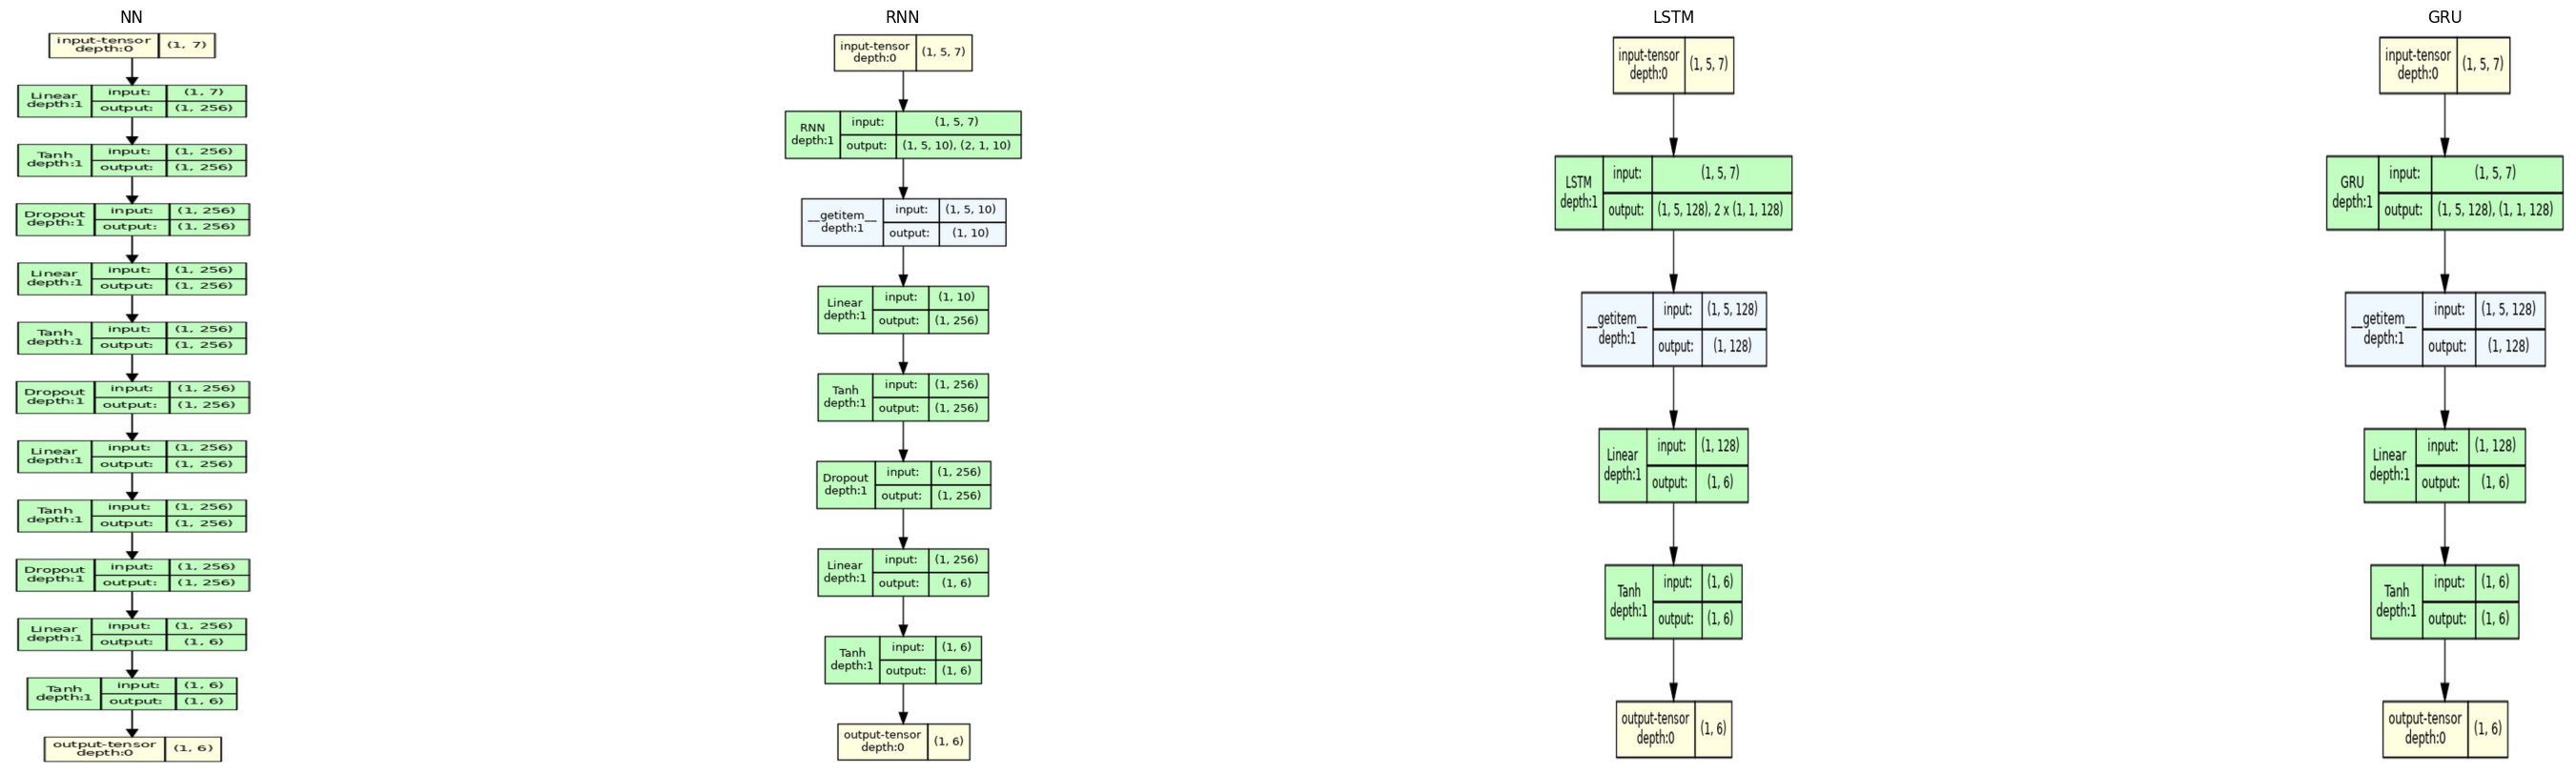

In [4]:
from utils.ML1.model_defenitions import RNN, GRU, LSTM
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(256, 256)
        nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 256)
        nn.init.xavier_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(256, output_size)
        nn.init.xavier_normal_(self.fc4.weight)
        self.activation = nn.Tanh()
        self.output_activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.dropout(out)
        out = self.activation(self.fc2(out))
        out = self.dropout(out)
        out = self.activation(self.fc3(out))
        out = self.dropout(out)
        out = self.output_activation(self.fc4(out))
        return out
visualize_models()

## 3.3.4 Traning

In [5]:
#Hyperparameters
learning_rate = 0.0002
EPOCHS = 5
BATCH_SIZE = 2048

input_size = 7 # number of input features 
output_size = 6 # number of output (6 fts readings)

dataset = CustomDatasetFromCSV(csv_path = '/mnt/data/ML1/data.csv',mode="train")

train_length = int(0.75* len(dataset))
test_length = len(dataset)-train_length
train_dataset,test_dataset=torch.utils.data.random_split(dataset,(train_length,test_length))

In [6]:
import os

file_path = "utils/ML1/models/NN_model.pt"
if os.path.exists(file_path):
    print("using pre-trained model")
    nn_model = torch.jit.load('utils/ML1/models/NN_model.pt', map_location=torch.device('cpu'))
    rnn_model = torch.jit.load('utils/ML1/models/RNN_model.pt', map_location=torch.device('cpu'))
    gru_model = torch.jit.load('utils/ML1/models/GRU_model.pt', map_location=torch.device('cpu'))
    lstm_model = torch.jit.load('utils/ML1/models/LSTM_model.pt', map_location=torch.device('cpu'))
else:
    model = NN(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    
    # Train the model
    n_total_steps = len(train_dataloader)
    for epoch in range(EPOCHS):
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for i, (X, y) in enumerate(progress_bar): 
            #Forward propagation
            y_pred = model(X)
            loss = criterion(y_pred, y)
            # Backpropagation and optimize
            model.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': loss.item()})

using pre-trained model


## 3.3.3 Resuts

The results from the 4 differents models on the same validation trajectory which was not used for training is given below

In [7]:

#to denormalize the predictions
y_max = torch.load('utils/ML1/models/y_max.pt',map_location=torch.device('cpu'))
y_min = torch.load('utils/ML1/models/y_min.pt',map_location=torch.device('cpu'))

dataset = CustomDatasetFromCSV(csv_path = 'utils/ML1/validate.csv', device = "cpu", mode="test")
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()

pred_list = []
with torch.no_grad():    
    for i, (X,y) in enumerate(tqdm(test_dataloader)):
        
        pred = model(X)
        pred = (pred+1)/2* (y_max - y_min) + y_min
        pred_list.append(pred)

#denormalize the data

y_truth = ((test_dataloader.dataset.y + 1)/2* (y_max - y_min) + y_min).cpu().numpy()
pred_list = torch.cat(pred_list).numpy()
pred_list = pred_list.squeeze(1)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plotting each component
components = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']
for i, ax in enumerate(axes.flat):
    if i < y_truth.shape[1]:  # Ensure there are enough columns to plot
        ax.plot(y_truth[:, i], label="truth")
        ax.plot(pred_list[:, i], label="prediction")
        ax.set_title(components[i])
    else:
        ax.set_visible(False)

# Add legend to the first subplot
axes[0, 0].legend()
# Display the plot
plt.tight_layout()
plt.show()




NameError: name 'model' is not defined

Feaure importance study

it is clear that GRU performs the best out of all. it is to be noted that hypermarameter optimization was not done for nay of these models and a set of recommended parameters were used for an initial comparison, although these results might vary when each model is further optimized , hwoever this will be done in the next chapter. But for a good first comparison this seems good. use of GRU or a recurrent neural network is also important as there are physical properties of the joint like hystersisi which rely on the previous state of the joint. hence moving forward the GRU architecture will be used. 

## 3.3.4 Comparison with baseline approaches
show how analytical methods fail when other joints are moving.

In [ ]:
input_df = pd.read_csv('utils/ML1/validate.csv')
pred_df = pd.DataFrame(pred_list, columns = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz'])
#create empty arrays to store the results
measured_external_force = np.zeros((len(input_df),6))
calculated_external_force = np.zeros((len(input_df),6))
estimated_external_force = np.zeros((len(input_df),6))

for i, row in input_df.iterrows():

    joint_angle = row[["joint_angles_1","joint_angles_2","joint_angles_3","joint_angles_4","joint_angles_5","joint_angles_6"]].values
    joint_angle = np.array(joint_angle)
    #print(joint_angle)
    jacobian = compute_geometric_jacobian(joint_angle)
    

    joint_torque = row[["joint_torque_current_1","joint_torque_current_2","joint_torque_current_3","joint_torque_current_4","joint_torque_current_5","joint_torque_current_6"]].values
    joint_torque = np.array(joint_torque)

    idyn_torque = row[["target_joint_torque_1","target_joint_torque_2","target_joint_torque_3","target_joint_torque_4","target_joint_torque_5","target_joint_torque_6"]].values
    idyn_torque = np.array(idyn_torque)
    
    fts_reading = row[["fts_reading_1","fts_reading_2","fts_reading_3","fts_reading_4","fts_reading_5","fts_reading_6"]]
    fts_reading = np.array(fts_reading)
    
    measured_external_force[i] = jacobian.T@fts_reading
    calculated_external_force[i] = joint_torque - idyn_torque
    try:
        estimated_external_force[i] = jacobian.T@pred_df.iloc[i].values # the dropna in the dataset will cause the index to be different could cause shifts in plot
    except Exception as e:
        print(e)
        continue
    
#plot the results

plt.suptitle('Comparison of measured (FTS), calculated (Motor torque - IDYN) \n and estimated (ML model)external forces and torques')

plt.plot(measured_external_force[:,2],label="measured")
plt.plot(calculated_external_force[:,2],label="calculated")
plt.plot(estimated_external_force[:,2],label="estimated")
plt.legend()
plt.xlabel('idx')
plt.ylabel('Force(N)')





from this it is clear that a machine learning based approach is quite suitable to model external joint torques. This leads to the next chapter where a single model will be used to predict the fts based on inputs from all the 6 joints.